In [1]:
# Cell 1: Importing Libraries

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Randomized Search for tuning
from sklearn.model_selection import RandomizedSearchCV

# XGBoost
from xgboost import XGBRegressor

# SHAP (Explainability)
import shap

# Display full columns
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Load the PLE dataset and preview

# Load the dataset
df = pd.read_csv("C:/Users/MARKOEL/Documents/ple_analysis.csv")

# Preview the first 10 rows
print("Preview of the dataset:")
display(df.head(10))

# Dataset structure
print("\nDataset Info:")
print(df.info())

# Summary statistics for numeric columns
print("\nSummary Statistics:")
display(df.describe())

# Check unique values in key columns
print


Preview of the dataset:


,district_id,county_id,subcounty_id,parish_id,district,county,subcounty,parish,year,school_name,ownership,gender,grade,value
0,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 1,16.0
1,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 1,5.0
2,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 2,3.0
3,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 2,6.0
4,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 3,0.0
5,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 3,0.0
6,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 4,0.0
7,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 4,0.0
8,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division U,0.0
9,d101,c101,s109,p145,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division U,0.0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district_id   5112 non-null   object 
 1   county_id     5100 non-null   object 
 2   subcounty_id  5100 non-null   object 
 3   parish_id     4836 non-null   object 
 4   district      5112 non-null   object 
 5   county        5100 non-null   object 
 6   subcounty     5100 non-null   object 
 7   parish        4860 non-null   object 
 8   year          5112 non-null   int64  
 9   school_name   5112 non-null   object 
 10  ownership     5101 non-null   object 
 11  gender        5112 non-null   object 
 12  grade         5112 non-null   object 
 13  value         5098 non-null   float64
dtypes: float64(1), int64(1), object(12)
memory usage: 559.3+ KB
None

Summary Statistics:


,year,value
count,5112.000000,5098.000000
mean,2020.323944,3.100432
std,1.894887,5.507634
min,2018.000000,0.000000
25%,2019.000000,0.000000
50%,2020.000000,1.000000
75%,2022.000000,4.000000
max,2023.000000,70.000000


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [3]:
# Cell 3: Data Preprocessing Before Feature Engineering

# Make a copy to avoid modifying the original data
df_clean = df.copy()

print("Initial dataset shape:", df_clean.shape)

# -----------------------------------------
# 1. DROP UNNECESSARY ID COLUMNS
# -----------------------------------------
cols_to_drop = ["district_id", "county_id", "subcounty_id", "parish_id"]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

print("After dropping ID columns:", df_clean.shape)
print(df_clean.columns)


# -----------------------------------------
# 2. CHECK MISSING VALUES
# -----------------------------------------
print("\nMissing values before cleaning:")
print(df_clean.isna().sum())


# -----------------------------------------
# 3. HANDLE MISSING VALUES
# -----------------------------------------

# Fill missing categorical values with "Unknown"
categorical_cols = ["district", "county", "subcounty", "parish", 
                    "school_name", "ownership", "gender", "grade"]

for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna("Unknown")

# Fill missing numerical values (if any) with 0
if 'value' in df_clean.columns:
    df_clean['value'] = df_clean['value'].fillna(0)

# -----------------------------------------
# 4. ENFORCE CORRECT DATA TYPES
# -----------------------------------------

# Ensure year is int
if 'year' in df_clean.columns:
    df_clean['year'] = df_clean['year'].astype(int)

# Ensure grade/division is string for pivoting
df_clean['grade'] = df_clean['grade'].astype(str)

print("\nMissing values after cleaning:")
print(df_clean.isna().sum())

print("\nPreview after preprocessing:")
display(df_clean.head())


Initial dataset shape: (5112, 14)
After dropping ID columns: (5112, 10)
Index(['district', 'county', 'subcounty', 'parish', 'year', 'school_name',
       'ownership', 'gender', 'grade', 'value'],
      dtype='object')

Missing values before cleaning:
district         0
county          12
subcounty       12
parish         252
year             0
school_name      0
ownership       11
gender           0
grade            0
value           14
dtype: int64

Missing values after cleaning:
district       0
county         0
subcounty      0
parish         0
year           0
school_name    0
ownership      0
gender         0
grade          0
value          0
dtype: int64

Preview after preprocessing:


,district,county,subcounty,parish,year,school_name,ownership,gender,grade,value
0,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 1,16.0
1,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 1,5.0
2,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 2,3.0
3,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Female,Division 2,6.0
4,Masindi,Buruli,Miirya,Isimba,2018,Walyoba Brilliant Primary School,Private,Male,Division 3,0.0


In [4]:
# Cell 4 : Clean Grade Column + Feature Engineering

# ----------------------------------------
# 1. CLEAN THE GRADE COLUMN
# ----------------------------------------
# Extract the numeric part of 'Division 1', 'Division 2', etc.
df_clean['grade_clean'] = df_clean['grade'].str.extract('(\d+)', expand=False)

# Convert extracted grade to string for pivoting
df_clean['grade_clean'] = df_clean['grade_clean'].astype(str)

print("Unique cleaned grade values:", df_clean['grade_clean'].unique())


# ----------------------------------------
# 2. PIVOT TABLE TO CREATE Div1–Div4 COLUMNS
# ----------------------------------------
pivot_df = df_clean.pivot_table(
    index=["year", "school_name", "district", "county", "subcounty", "parish", "ownership", "gender"],
    columns="grade_clean",
    values="value",
    aggfunc="sum",
    fill_value=0
).reset_index()

print("\nPivot shape:", pivot_df.shape)

# ----------------------------------------
# 3. Rename columns to Div1–Div4
# ----------------------------------------
pivot_df = pivot_df.rename(columns={
    '1': 'Div1',
    '2': 'Div2',
    '3': 'Div3',
    '4': 'Div4'
})

# Ensure missing columns exist
for col in ["Div1", "Div2", "Div3", "Div4"]:
    if col not in pivot_df.columns:
        pivot_df[col] = 0

# ----------------------------------------
# 4. Compute Total Students
# ----------------------------------------
pivot_df["Total_Students"] = pivot_df[["Div1", "Div2", "Div3", "Div4"]].sum(axis=1)

pivot_df = pivot_df[pivot_df["Total_Students"] > 0]

# ----------------------------------------
# 5. Compute Weighted Aggregate Score
# ----------------------------------------
pivot_df["Weighted_Aggregate"] = (
    pivot_df["Div1"] * 8 +
    pivot_df["Div2"] * 18 +
    pivot_df["Div3"] * 26 +
    pivot_df["Div4"] * 33
) / pivot_df["Total_Students"]

print("\nWeighted Aggregate Feature Engineering Complete!\n")

display(pivot_df.head(15))
print("\nFinal dataset shape:", pivot_df.shape)


Unique cleaned grade values: ['1' '2' '3' '4' 'nan']

Pivot shape: (853, 13)

Weighted Aggregate Feature Engineering Complete!



grade_clean,year,school_name,district,county,subcounty,parish,ownership,gender,Div1,Div2,Div3,Div4,nan,Total_Students,Weighted_Aggregate
0,2018,Alimugonza Primary School,Masindi,Buruli,Pakanyi,Kyakamese Central,Government,Female,0.0,6.0,4.0,2.0,0.0,12.0,23.166667
1,2018,Alimugonza Primary School,Masindi,Buruli,Pakanyi,Kyakamese Central,Government,Male,0.0,12.0,6.0,2.0,2.0,20.0,21.900000
2,2018,Alinda Primary School,Masindi,Bujenje,Bikonzi,Kitonozi,Private,Female,0.0,5.0,2.0,1.0,1.0,8.0,21.875000
3,2018,Alinda Primary School,Masindi,Bujenje,Bikonzi,Kitonozi,Private,Male,0.0,2.0,1.0,1.0,2.0,4.0,23.750000
4,2018,Arise and Prosper Primary School,Masindi,Buruli,Kijunjubwa,Kijunjubwa,Private,Female,2.0,21.0,2.0,1.0,0.0,26.0,18.423077
5,2018,Arise and Prosper Primary School,Masindi,Buruli,Kijunjubwa,Kijunjubwa,Private,Male,4.0,19.0,0.0,0.0,0.0,23.0,16.260870
6,2018,Bizige Primary School,Masindi,Bujenje,Bulima Town Council,Kisalizi Ward,Private,Female,0.0,4.0,2.0,0.0,2.0,6.0,20.666667
7,2018,Bizige Primary School,Masindi,Bujenje,Bulima Town Council,Kisalizi Ward,Private,Male,0.0,0.0,0.0,2.0,0.0,2.0,33.000000
8,2018,Blessed Damian Primary School,Masindi,Buruli,Kyatiri Town Council,Kyatiri East Ward,Private,Female,0.0,21.0,0.0,1.0,1.0,22.0,18.681818
9,2018,Blessed Damian Primary School,Masindi,Buruli,Kyatiri Town Council,Kyatiri East Ward,Private,Male,4.0,14.0,0.0,1.0,0.0,19.0,16.684211



Final dataset shape: (840, 15)


Starting EDA...



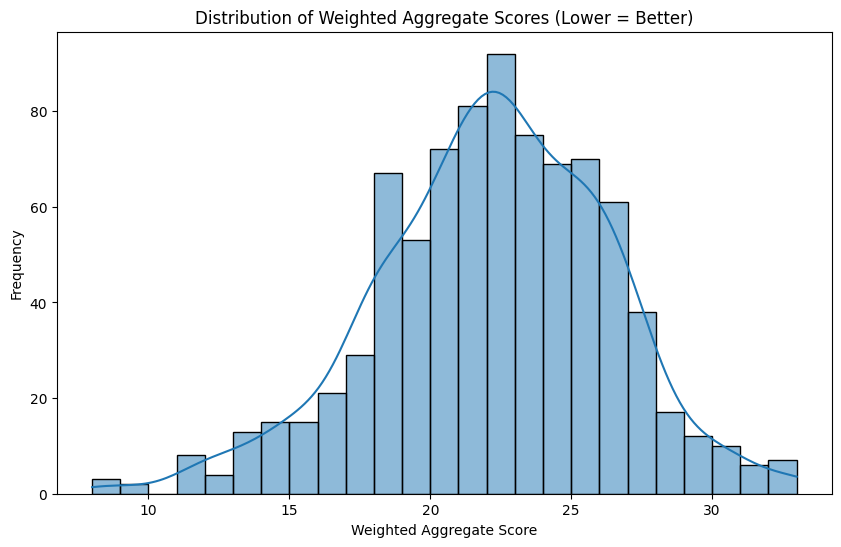

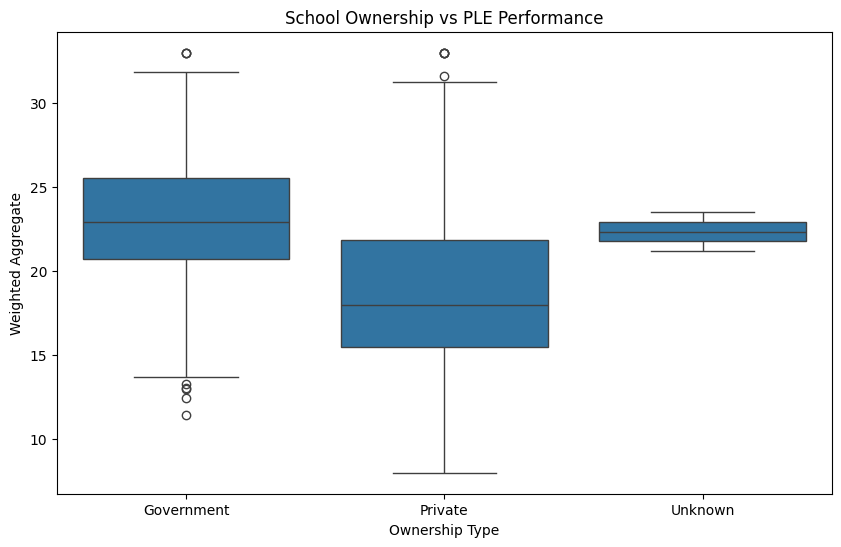

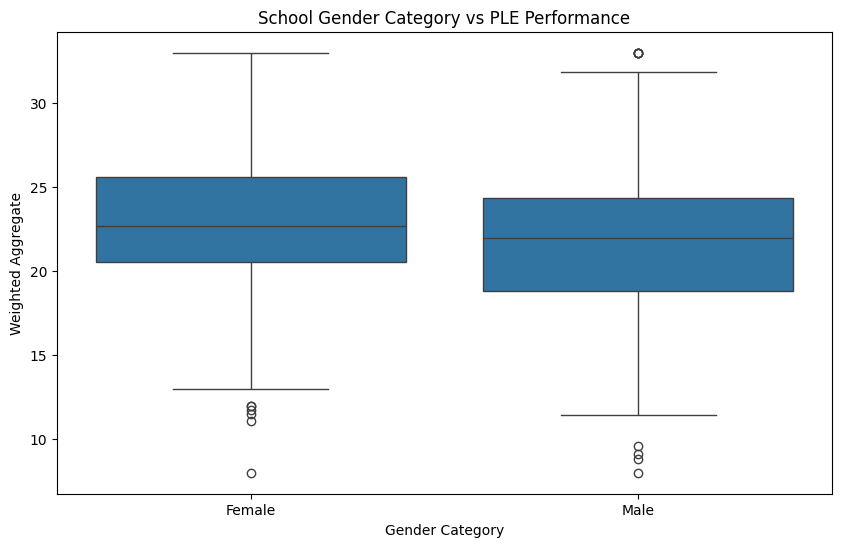

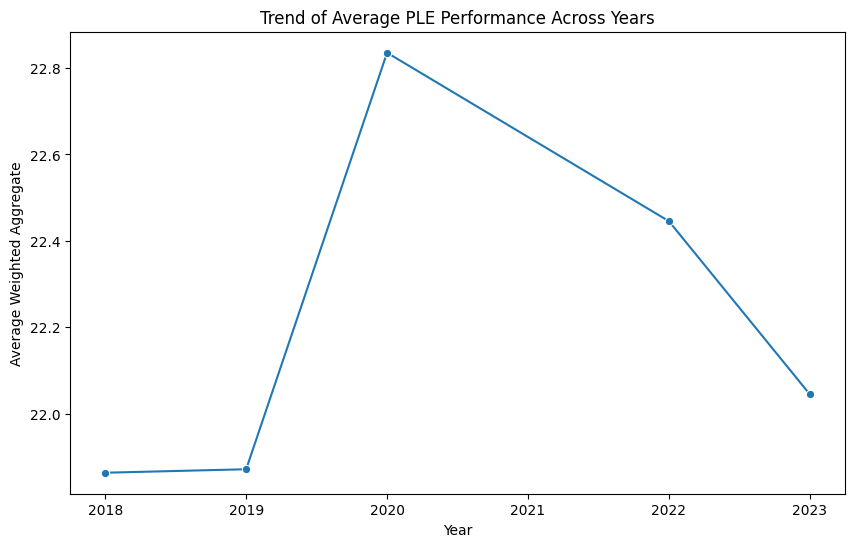

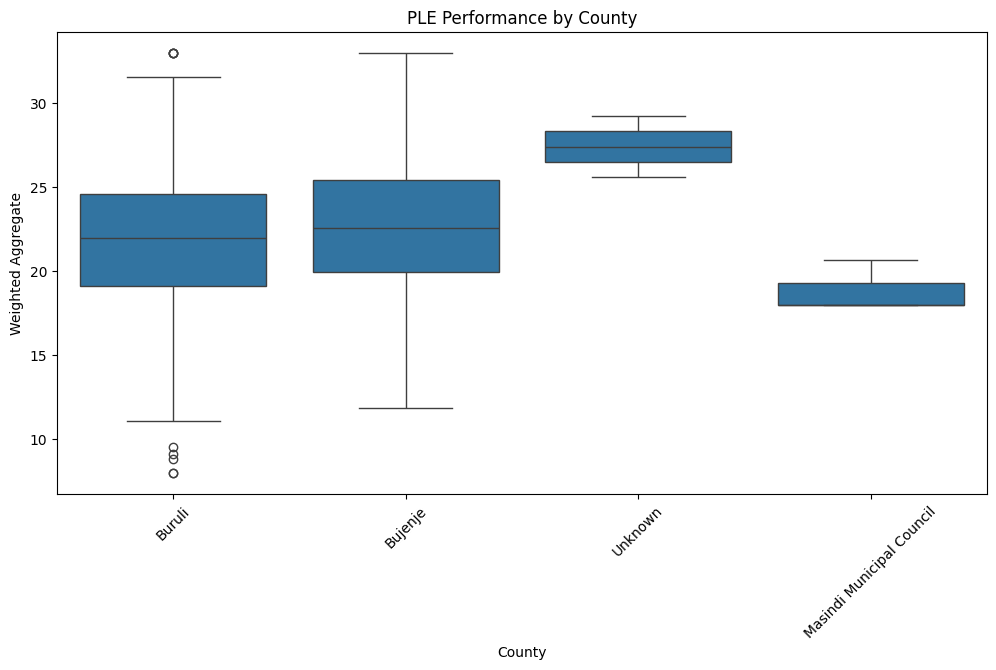

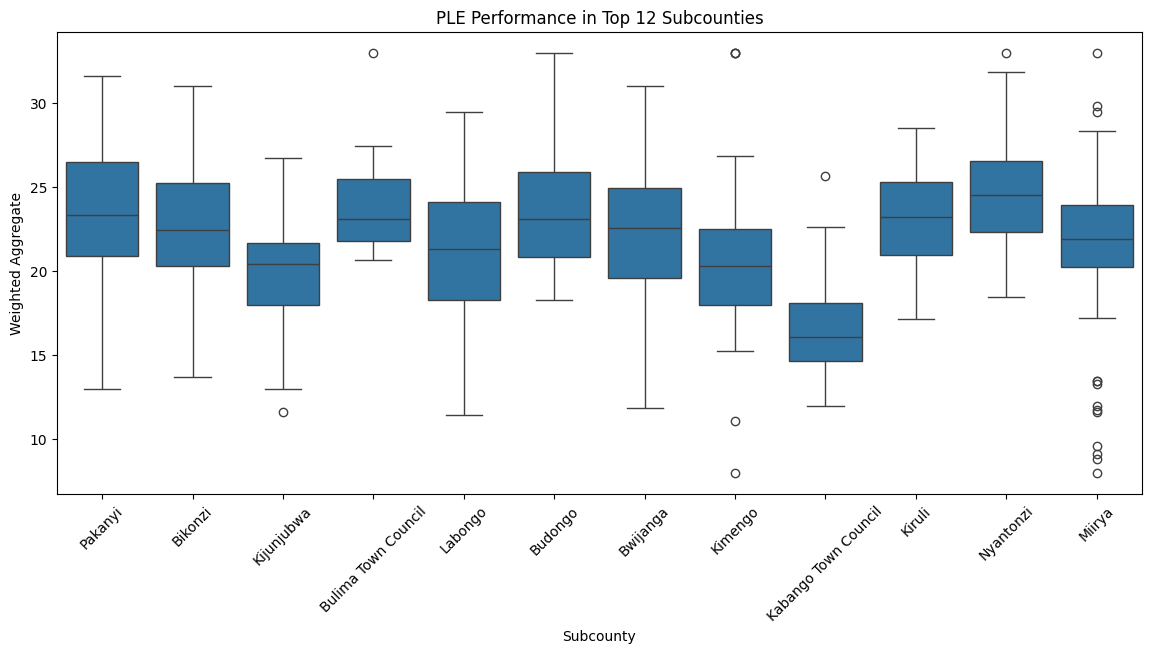

EDA complete.


In [5]:
# Cell 5: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

print("Starting EDA...\n")

# -----------------------------------------------------
# 1. Distribution of Weighted Aggregate
# -----------------------------------------------------
plt.figure(figsize=(10,6))
sns.histplot(pivot_df["Weighted_Aggregate"], kde=True, bins=25)
plt.title("Distribution of Weighted Aggregate Scores (Lower = Better)")
plt.xlabel("Weighted Aggregate Score")
plt.ylabel("Frequency")
plt.show()

# -----------------------------------------------------
# 2. Boxplot: Performance by Ownership
# -----------------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=pivot_df, x="ownership", y="Weighted_Aggregate")
plt.title("School Ownership vs PLE Performance")
plt.xlabel("Ownership Type")
plt.ylabel("Weighted Aggregate")
plt.show()

# -----------------------------------------------------
# 3. Boxplot: Performance by Gender Category
# -----------------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=pivot_df, x="gender", y="Weighted_Aggregate")
plt.title("School Gender Category vs PLE Performance")
plt.xlabel("Gender Category")
plt.ylabel("Weighted Aggregate")
plt.show()

# -----------------------------------------------------
# 4. Trend of Performance Over the Years
# -----------------------------------------------------
yearly_avg = pivot_df.groupby("year")["Weighted_Aggregate"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_avg, x="year", y="Weighted_Aggregate", marker="o")
plt.title("Trend of Average PLE Performance Across Years")
plt.xlabel("Year")
plt.ylabel("Average Weighted Aggregate")
plt.show()

# -----------------------------------------------------
# 5. County Performance Comparison
# -----------------------------------------------------
plt.figure(figsize=(12,6))
sns.boxplot(data=pivot_df, x="county", y="Weighted_Aggregate")
plt.xticks(rotation=45)
plt.title("PLE Performance by County")
plt.xlabel("County")
plt.ylabel("Weighted Aggregate")
plt.show()

# -----------------------------------------------------
# 6. Subcounty Performance Comparison (Top 12)
# -----------------------------------------------------
top_subcounties = pivot_df["subcounty"].value_counts().index[:12]

plt.figure(figsize=(14,6))
sns.boxplot(
    data=pivot_df[pivot_df["subcounty"].isin(top_subcounties)],
    x="subcounty", y="Weighted_Aggregate"
)
plt.xticks(rotation=45)
plt.title("PLE Performance in Top 12 Subcounties")
plt.xlabel("Subcounty")
plt.ylabel("Weighted Aggregate")
plt.show()

print("EDA complete.")


In [6]:
# Cell 6: Prepare Modeling Dataset (X and y) + Preprocessing Pipelines

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("Preparing X and y for modeling...\n")

# -------------------------------------------
# 1. Define Target Variable (Weighted Aggregate)
# -------------------------------------------
y = pivot_df["Weighted_Aggregate"]

# -------------------------------------------
# 2. Define Feature Set (X)
# -------------------------------------------
# Drop target and keep relevant predictors
X = pivot_df.drop(columns=["Weighted_Aggregate"])

print("X shape:", X.shape)
print("y shape:", y.shape)

# -------------------------------------------
# 3. Select Feature Types
# -------------------------------------------
numeric_features = ["Div1", "Div2", "Div3", "Div4", "Total_Students"]
categorical_features = ["district", "county", "subcounty", "parish", "ownership", "gender", "school_name", "year"]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# -------------------------------------------
# 4. Build Preprocessing Pipelines
# -------------------------------------------

numeric_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)

print("\nPreprocessor created successfully.")

# -------------------------------------------
# 5. Train-Test Split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)

print("\nCell 6 complete — dataset ready for modeling!")

Preparing X and y for modeling...

X shape: (840, 14)
y shape: (840,)
Numeric features: ['Div1', 'Div2', 'Div3', 'Div4', 'Total_Students']
Categorical features: ['district', 'county', 'subcounty', 'parish', 'ownership', 'gender', 'school_name', 'year']

Preprocessor created successfully.

Training set size: (672, 14)
Test set size: (168, 14)

Cell 6 complete — dataset ready for modeling!


Training baseline models...

Training: Linear Regression
Training: Ridge Regression
Training: Lasso Regression
Training: Random Forest
Training: Gradient Boosting
Training: XGBoost

===== BASELINE MODEL PERFORMANCE =====


,Model,RMSE,MAE,R2
5,XGBoost,0.289352,0.205625,0.995096
3,Random Forest,0.511395,0.356395,0.984682
4,Gradient Boosting,0.652018,0.419982,0.975099
1,Ridge Regression,2.142692,1.460658,0.731087
0,Linear Regression,2.205518,1.491186,0.715086
2,Lasso Regression,3.099653,2.288933,0.437246



Cell 7 complete.


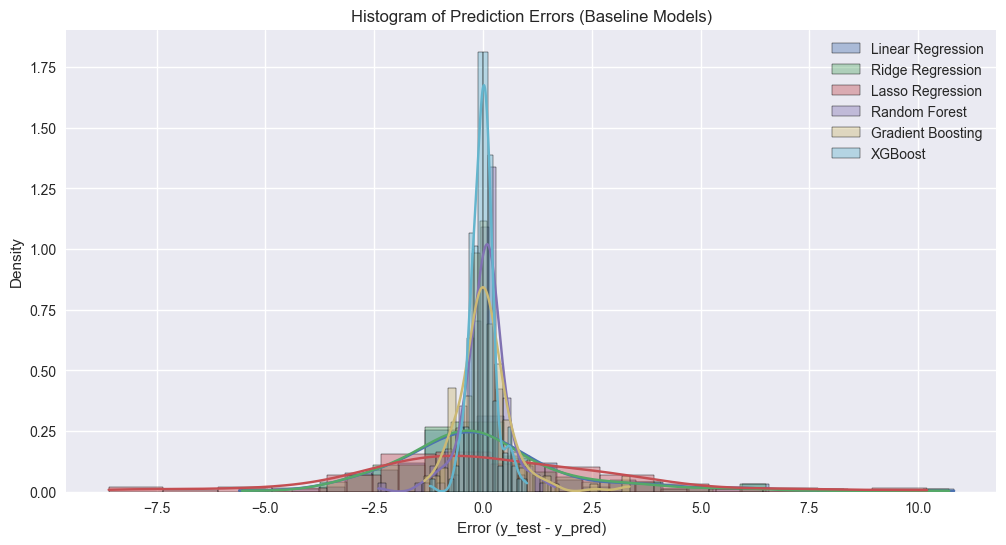

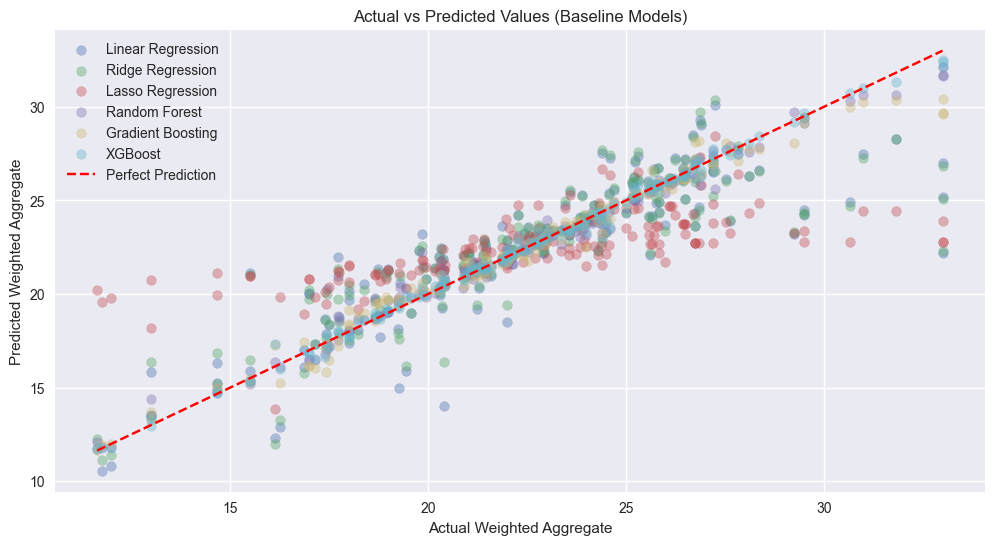

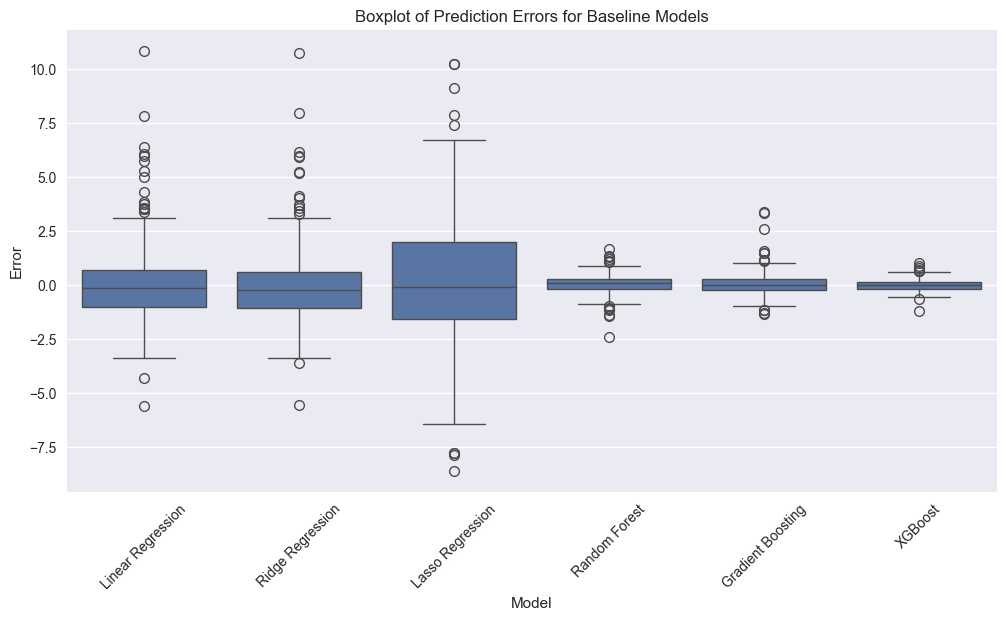

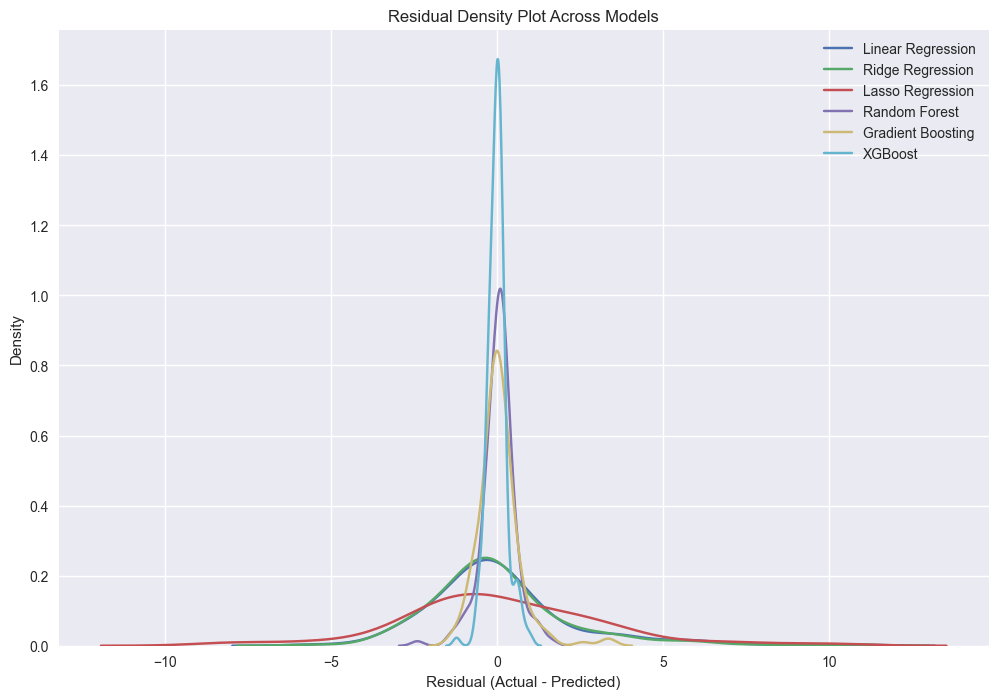

Baseline visualizations completed.


In [38]:
# Cell 7: Baseline Model Training and Evaluation

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np

print("Training baseline models...\n")

# --------------------------------------
# Wrap models in the preprocessing pipeline
# --------------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    )
}

results = []

for name, model in models.items():
    print(f"Training: {name}")
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append([name, rmse, mae, r2])

print("\n===== BASELINE MODEL PERFORMANCE =====")
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
display(results_df.sort_values("RMSE"))

print("\nCell 7 complete.")
# ================================================================
# Baseline Model Error Visualizations (Add to Cell 7)
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare for visualization
plt.style.use("seaborn-v0_8")

# Get predictions for each model for plotting
model_preds = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    model_preds[name] = preds

# ================================================================
# 1️⃣ Histogram of Prediction Errors for all models
# ================================================================
plt.figure(figsize=(12, 6))

for name, preds in model_preds.items():
    errors = y_test - preds
    sns.histplot(errors, kde=True, label=name, stat="density", alpha=0.4)

plt.title("Histogram of Prediction Errors (Baseline Models)")
plt.xlabel("Error (y_test - y_pred)")
plt.ylabel("Density")
plt.legend()
plt.show()

# ================================================================
# 2️⃣ Scatter Plot: Actual vs Predicted for each model
# ================================================================
plt.figure(figsize=(12, 6))

for name, preds in model_preds.items():
    plt.scatter(y_test, preds, alpha=0.4, label=name)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label="Perfect Prediction")

plt.title("Actual vs Predicted Values (Baseline Models)")
plt.xlabel("Actual Weighted Aggregate")
plt.ylabel("Predicted Weighted Aggregate")
plt.legend()
plt.show()

# ================================================================
# 3️⃣ Boxplot of Model Errors
# ================================================================
all_errors = []

for name, preds in model_preds.items():
    for e in (y_test - preds):
        all_errors.append([name, e])

error_df = pd.DataFrame(all_errors, columns=["Model", "Error"])

plt.figure(figsize=(12, 6))
sns.boxplot(data=error_df, x="Model", y="Error")
plt.xticks(rotation=45)
plt.title("Boxplot of Prediction Errors for Baseline Models")
plt.show()

# ================================================================
# 4️⃣ Residual Distribution (per model)
# ================================================================
plt.figure(figsize=(12, 8))

for name, preds in model_preds.items():
    sns.kdeplot(y_test - preds, label=name, fill=False)

plt.title("Residual Density Plot Across Models")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Baseline visualizations completed.")

In [9]:
# Cell X: k-Fold Cross Validation for Baseline Models

from sklearn.model_selection import cross_val_score

print("Performing 5-Fold Cross Validation...\n")

cv_results = []

for name, model in models.items():
    print(f"Cross-validating: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    cv_rmse = -cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    
    cv_results.append([name, cv_rmse.mean(), cv_rmse.std()])

cv_df = pd.DataFrame(cv_results, columns=["Model", "CV Mean RMSE", "CV Std"])
display(cv_df.sort_values("CV Mean RMSE"))

print("\nCross-validation complete.")


Performing 5-Fold Cross Validation...

Cross-validating: Linear Regression
Cross-validating: Ridge Regression
Cross-validating: Lasso Regression
Cross-validating: Random Forest
Cross-validating: Gradient Boosting
Cross-validating: XGBoost


,Model,CV Mean RMSE,CV Std
5,XGBoost,0.504963,0.046052
4,Gradient Boosting,0.652370,0.037338
3,Random Forest,0.696560,0.116858
1,Ridge Regression,1.967660,0.110978
0,Linear Regression,2.015278,0.153350
2,Lasso Regression,3.052166,0.188402



Cross-validation complete.


In [10]:
# Cell 8: Hyperparameter Tuning for Top 3 Models
from sklearn.model_selection import RandomizedSearchCV

print("Starting hyperparameter tuning...\n")

# ===============================================
# 1. RANDOM FOREST TUNING
# ===============================================
rf_params = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [5, 10, 15, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_params,
    n_iter=20,
    cv=3,
    random_state=42,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest Params:", rf_search.best_params_)


# ===============================================
# 2. GRADIENT BOOSTING TUNING
# ===============================================
gb_params = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4, 5]
}

gb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_search = RandomizedSearchCV(
    gb_pipe,
    gb_params,
    n_iter=20,
    cv=3,
    random_state=42,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best Gradient Boosting Params:", gb_search.best_params_)


# ===============================================
# 3. XGBOOST TUNING
# ===============================================
xgb_params = {
    "model__n_estimators": [200, 300, 400, 600],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [3, 4, 5, 6],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42
    ))
])

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_params,
    n_iter=20,
    cv=3,
    random_state=42,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost Params:", xgb_search.best_params_)


print("\nCell 8 complete — all three top models tuned successfully.")

Starting hyperparameter tuning...

Best Random Forest Params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
Best Gradient Boosting Params: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best XGBoost Params: {'model__subsample': 0.7, 'model__n_estimators': 400, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__colsample_bytree': 1.0}

Cell 8 complete — all three top models tuned successfully.


Evaluating baseline and tuned models...

Evaluating: Linear Regression
Evaluating: Ridge Regression
Evaluating: Lasso Regression
Evaluating: Random Forest
Evaluating: Gradient Boosting
Evaluating: XGBoost
Evaluating: Random Forest (Tuned)
Evaluating: Gradient Boosting (Tuned)
Evaluating: XGBoost (Tuned)

===== FINAL MODEL PERFORMANCE =====


,Model,RMSE,MAE,R2
5,XGBoost,0.289352,0.205625,0.995096
7,Gradient Boosting (Tuned),0.294367,0.198539,0.994925
8,XGBoost (Tuned),0.333917,0.244717,0.993469
6,Random Forest (Tuned),0.490610,0.345606,0.985902
3,Random Forest,0.511395,0.356395,0.984682
4,Gradient Boosting,0.652018,0.419982,0.975099
1,Ridge Regression,2.142692,1.460658,0.731087
0,Linear Regression,2.205518,1.491186,0.715086
2,Lasso Regression,3.099653,2.288933,0.437246



Cell 9 complete — model comparison finished.
Visualizing model comparison...



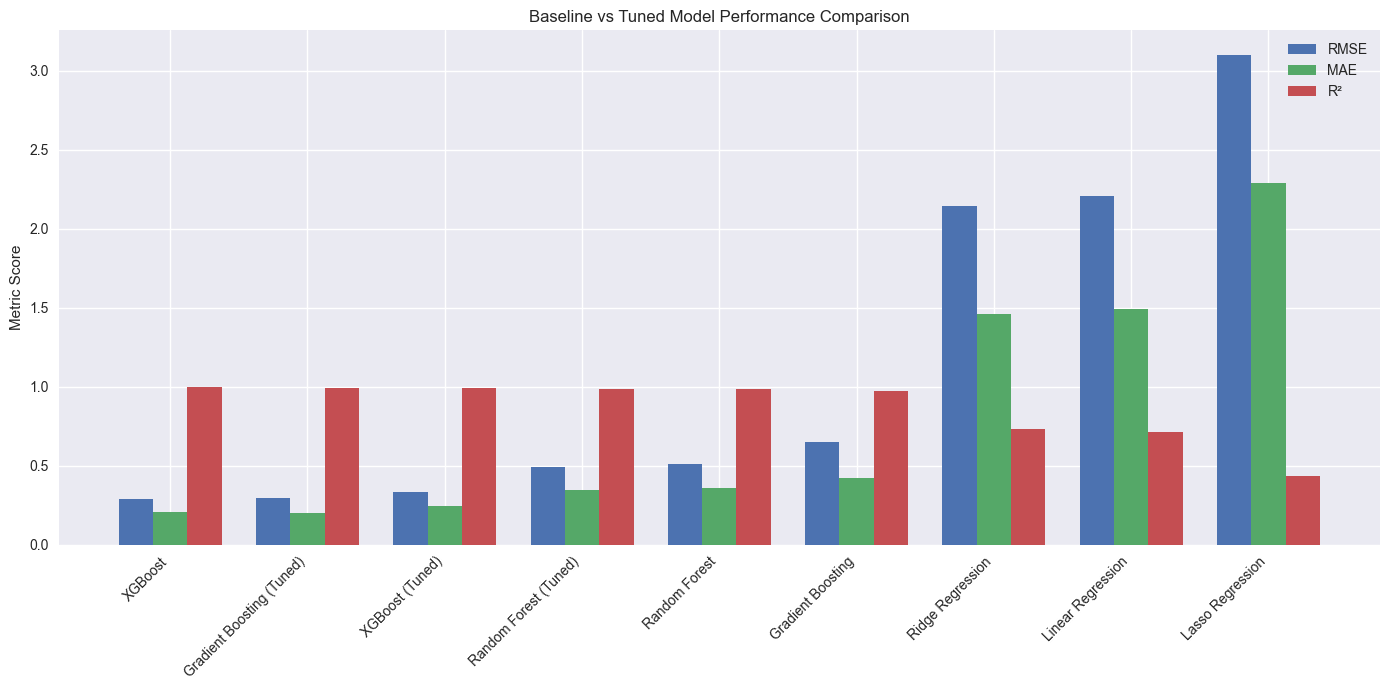

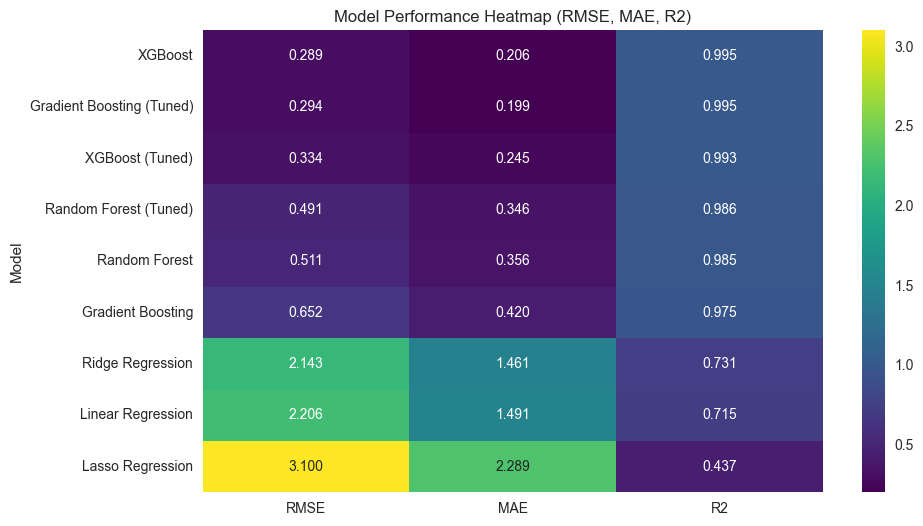

In [39]:
# Cell 9: Compare Baseline vs Tuned Models

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

print("Evaluating baseline and tuned models...\n")

# -----------------------------
# Baseline models from Cell 7
# -----------------------------
baseline_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    )
}

# Store results
results = []

# -----------------------------
# Evaluate Baseline Models
# -----------------------------
for name, model in baseline_models.items():
    print(f"Evaluating: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append([name, rmse, mae, r2])

# -----------------------------
# Evaluate Tuned Models
# -----------------------------
tuned_models = {
    "Random Forest (Tuned)": best_rf,
    "Gradient Boosting (Tuned)": best_gb,
    "XGBoost (Tuned)": best_xgb
}

for name, model in tuned_models.items():
    print(f"Evaluating: {name}")
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append([name, rmse, mae, r2])

# -----------------------------
# Display Final Comparison Table
# -----------------------------
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
results_df = results_df.sort_values("RMSE")  # best = lowest RMSE

print("\n===== FINAL MODEL PERFORMANCE =====")
display(results_df)

print("\nCell 9 complete — model comparison finished.")
# Cell 10: Visual Comparison of Baseline vs Tuned Models

import matplotlib.pyplot as plt
import numpy as np

print("Visualizing model comparison...\n")

# -------------------------
# Ensure numeric values
# -------------------------
results_df["RMSE"] = results_df["RMSE"].astype(float)
results_df["MAE"]  = results_df["MAE"].astype(float)
results_df["R2"]   = results_df["R2"].astype(float)

# -------------------------
# Grouped Bar Chart (RMSE, MAE, R2)
# -------------------------
models = results_df["Model"].tolist()
rmse = results_df["RMSE"].tolist()
mae  = results_df["MAE"].tolist()
r2   = results_df["R2"].tolist()

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14, 7))
plt.bar(x - width, rmse, width, label="RMSE")
plt.bar(x,         mae,  width, label="MAE")
plt.bar(x + width, r2,   width, label="R²")

plt.xticks(x, models, rotation=45, ha="right")
plt.ylabel("Metric Score")
plt.title("Baseline vs Tuned Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Cell X: Heatmap Comparison

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".3f", cmap="viridis")
plt.title("Model Performance Heatmap (RMSE, MAE, R2)")
plt.show()




 Top 10 XGBoost Built-In Feature Importances:


,feature,importance
3,Div4,0.478822
0,Div1,0.199287
1,Div2,0.149844
2,Div3,0.063624
57,parish_Ntoma,0.013253
17,subcounty_Kimengo,0.010887
53,parish_Kyakamese West,0.007849
44,parish_Kimanya,0.006750
16,subcounty_Kijunjubwa,0.006517
37,parish_Kibangya,0.004847


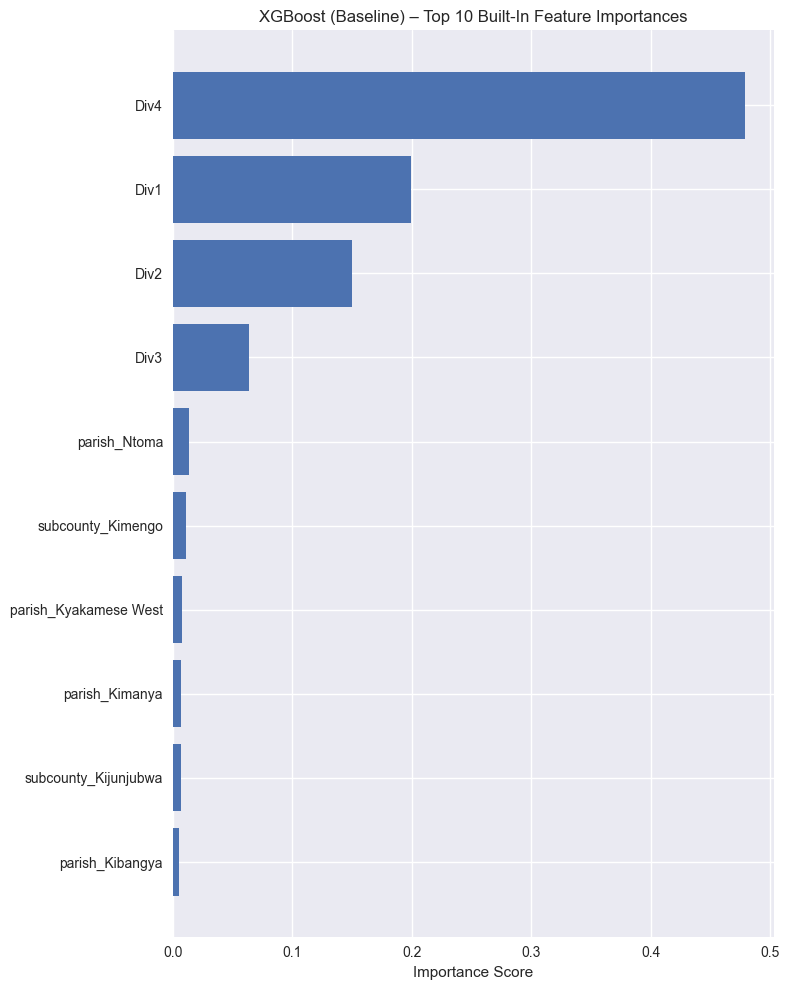


 Top 10 Permutation Importances:


,feature,importance
9,subcounty_Bikonzi,0.578314
11,subcounty_Bulima Town Council,0.474380
8,county_Masindi Municipal Council,0.205654
10,subcounty_Budongo,0.126057
13,subcounty_Central Division,0.001943
5,district_Masindi,0.000275
1,Div2,0.000062
6,county_Bujenje,0.000026
3,Div4,0.000007
2,Div3,0.000000


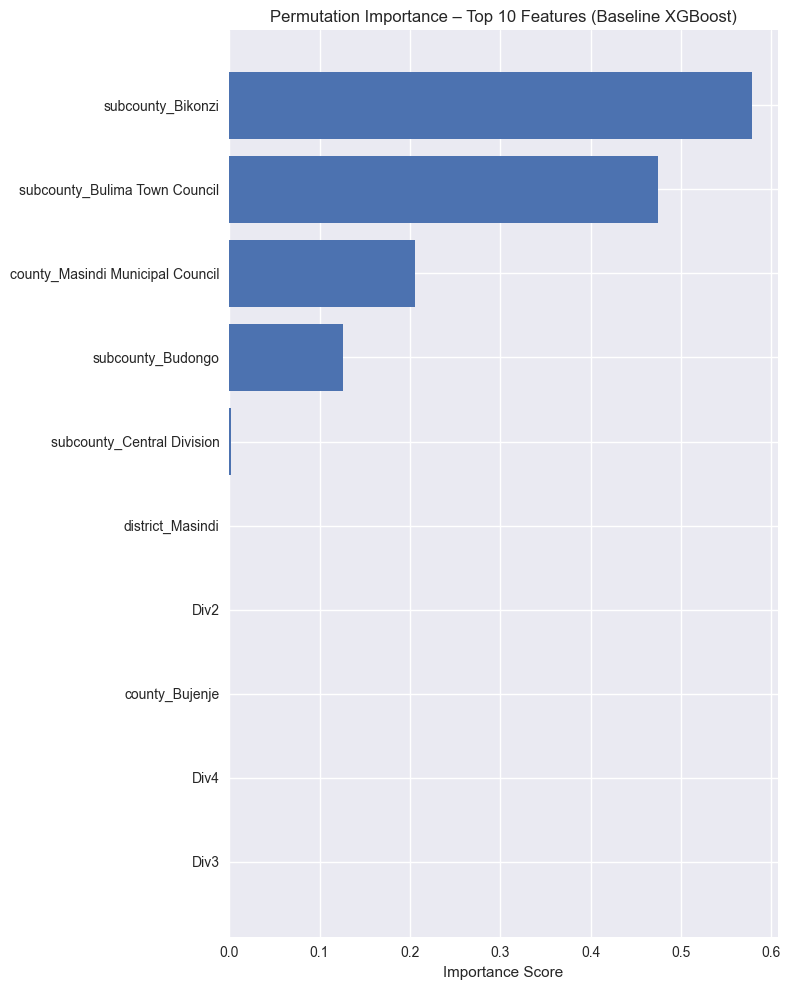

In [40]:
# ============================================
#  BASELINE XGBOOST FEATURE IMPORTANCE (WITH PLOTS)
# ============================================

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor   # <-- FIXED IMPORT
import matplotlib.pyplot as plt
import pandas as pd

# ---- Build baseline XGBoost model WITH preprocessing ----
best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    ))
])

# ---- Fit the baseline model ----
best_model.fit(X_train, y_train)

# ---- Identify steps ----
pre = best_model.named_steps["preprocessor"]
xgb_model = best_model.named_steps["model"]

# ---- Extract feature names ----
def get_feature_names(preprocessor):
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            ohe = trans.named_steps['onehot']
            feature_names.extend(ohe.get_feature_names_out(cols))
    return feature_names

feature_names = get_feature_names(pre)


# ============================================
# 1. XGBoost Built-In Importance
# ============================================

xgb_importances = xgb_model.feature_importances_
feature_names_xgb = feature_names[:len(xgb_importances)]

imp_df_xgb = pd.DataFrame({
    "feature": feature_names_xgb,
    "importance": xgb_importances
}).sort_values("importance", ascending=False)

print("\n Top 10 XGBoost Built-In Feature Importances:")
display(imp_df_xgb.head(10))

# --- Plot built-in importance ---
plt.figure(figsize=(8, 10))
plt.barh(imp_df_xgb.head(10)["feature"], imp_df_xgb.head(10)["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost (Baseline) – Top 10 Built-In Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


# ============================================
# 2. Permutation Importance
# ============================================

perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42
)

perm_mean = perm.importances_mean
feature_names_perm = feature_names[:len(perm_mean)]

imp_df_perm = pd.DataFrame({
    "feature": feature_names_perm,
    "importance": perm_mean
}).sort_values("importance", ascending=False)

print("\n Top 10 Permutation Importances:")
display(imp_df_perm.head(10))

# --- Plot permutation importance ---
plt.figure(figsize=(8, 10))
plt.barh(imp_df_perm.head(10)["feature"], imp_df_perm.head(10)["importance"])
plt.gca().invert_yaxis()
plt.title("Permutation Importance – Top 10 Features (Baseline XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


Preparing SHAP explanations for Baseline XGBoost...

SHAP values computed successfully.
Generating SHAP Summary Plot...


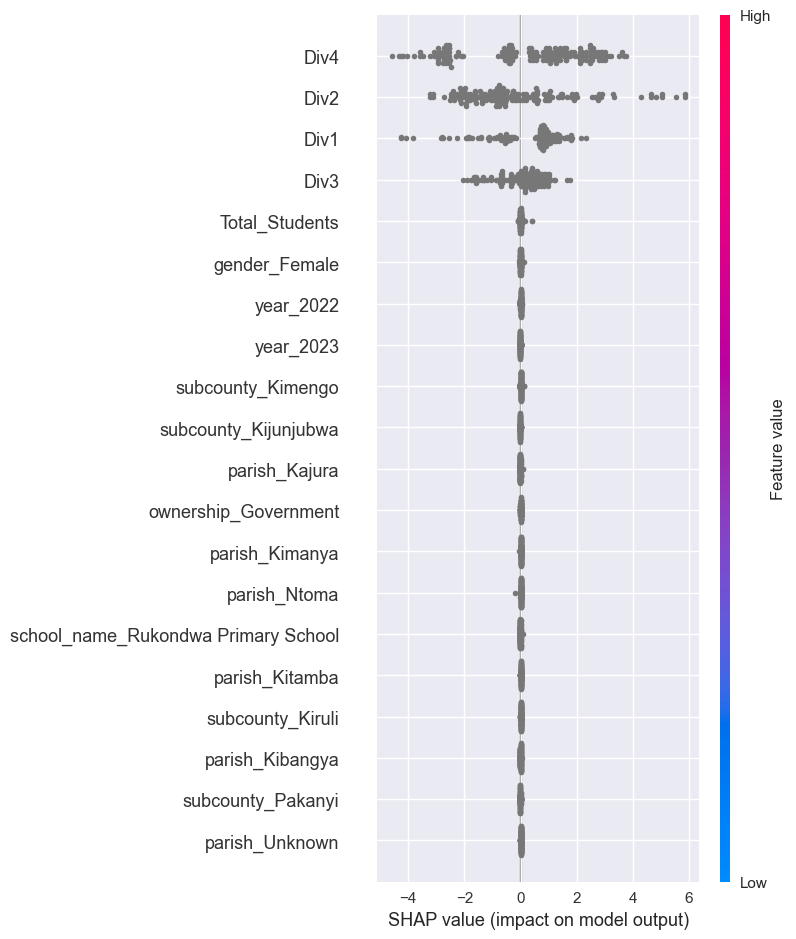

Generating SHAP Bar Plot...


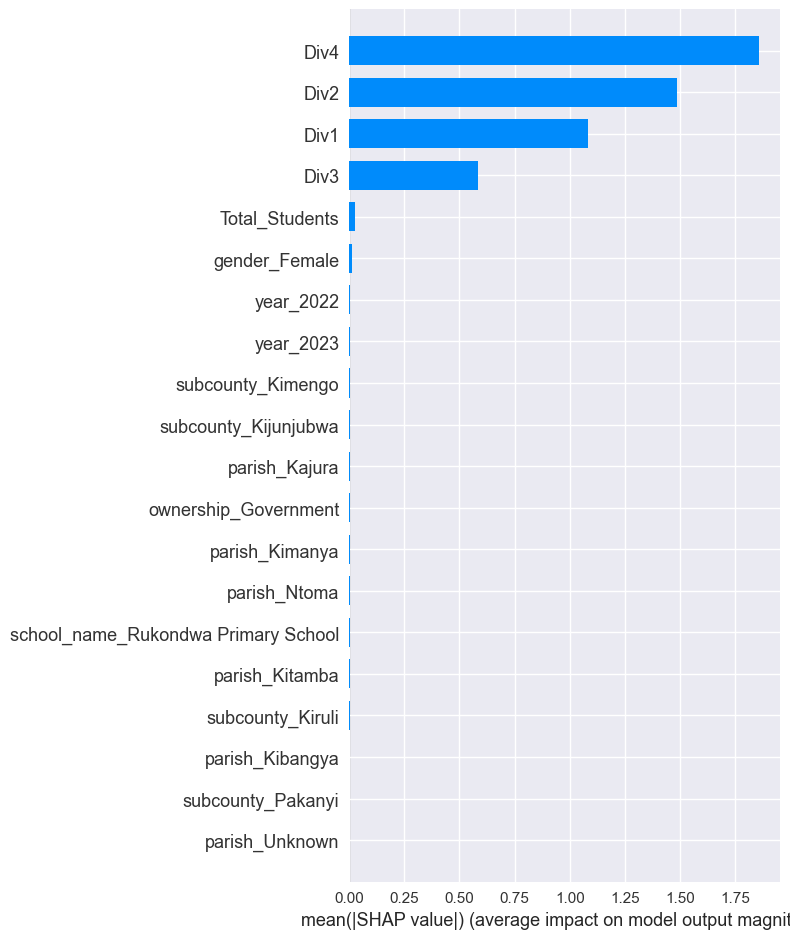


Generating Local Explanation for Sample #0...



================ SHAP INTERPRETATION (BASELINE XGBOOST) ================

 GLOBAL FEATURE IMPORTANCE
• The summary plot ranks features by average impact on predictions.
• Features with larger spreads (long tails) have stronger influence.
• Division counts (Div1, Div4, Div2, Div3) strongly influence performance.
• School-level contextual variables matter less but still contribute.

 HOW TO READ THE SUMMARY PLOT
• Red = high feature value, Blue = low feature value.
• If red points are mostly on the LEFT → high values reduce predicted aggregate (better).
• If red points are on the RIGHT → high values increase aggregate (worse).

 INTERPRETING BAR PLOT
• Shows mean(|SHAP value|) → overall feature power.
• Highlights the most influential variables regardless of direction.

 LOCAL EXPLANATION (Single Sample)
• Force plot shows WHY a particular prediction happened.
• Blue bars push the prediction down; red bars push it up.
• Helps explain individual school or year's performance patterns.

==

In [41]:
# ===============================================================
# SHAP EXPLAINABILITY FOR BASELINE XGBOOST MODEL
# ===============================================================

import shap
import numpy as np
import pandas as pd

print("Preparing SHAP explanations for Baseline XGBoost...\n")

# -----------------------------------------------
# 1. Fit Baseline XGBoost Pipeline
# -----------------------------------------------
baseline_xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    ))
])

baseline_xgb_pipeline.fit(X_train, y_train)

# Extract model + transformed features
preprocessor = baseline_xgb_pipeline.named_steps["preprocessor"]
xgb_model = baseline_xgb_pipeline.named_steps["model"]

X_test_transformed = preprocessor.transform(X_test)
feature_names = get_feature_names(preprocessor)

# -----------------------------------------------
# 2. NEW SHAP EXPLAINER
# -----------------------------------------------
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_transformed)

print("SHAP values computed successfully.")

# -----------------------------------------------
# 3. GLOBAL EXPLANATIONS
# -----------------------------------------------

# --- Summary Plot (beeswarm) ---
print("Generating SHAP Summary Plot...")
shap.summary_plot(
    shap_values.values,
    X_test_transformed,
    feature_names=feature_names,
    show=True
)

# --- Bar Plot (mean absolute SHAP) ---
print("Generating SHAP Bar Plot...")
shap.summary_plot(
    shap_values.values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# -----------------------------------------------
# 4. LOCAL EXPLANATION (Single Observation)
# -----------------------------------------------
sample_id = 0
print(f"\nGenerating Local Explanation for Sample #{sample_id}...")

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[sample_id],
    feature_names=feature_names
)

# ===============================================================
# TEXTUAL SHAP INTERPRETATION
# ===============================================================

print("\n================ SHAP INTERPRETATION (BASELINE XGBOOST) ================\n")

print(" GLOBAL FEATURE IMPORTANCE")
print("• The summary plot ranks features by average impact on predictions.")
print("• Features with larger spreads (long tails) have stronger influence.")
print("• Division counts (Div1, Div4, Div2, Div3) strongly influence performance.")
print("• School-level contextual variables matter less but still contribute.")

print("\n HOW TO READ THE SUMMARY PLOT")
print("• Red = high feature value, Blue = low feature value.")
print("• If red points are mostly on the LEFT → high values reduce predicted aggregate (better).")
print("• If red points are on the RIGHT → high values increase aggregate (worse).")

print("\n INTERPRETING BAR PLOT")
print("• Shows mean(|SHAP value|) → overall feature power.")
print("• Highlights the most influential variables regardless of direction.")

print("\n LOCAL EXPLANATION (Single Sample)")
print("• Force plot shows WHY a particular prediction happened.")
print("• Blue bars push the prediction down; red bars push it up.")
print("• Helps explain individual school or year's performance patterns.")

print("\n================ END OF SHAP ANALYSIS ================")


Intercept 21.092535267239192
Prediction_local [14.6966179]
Right: 17.128134

🔎 LIME EXPLANATION FOR SAMPLE #0



None

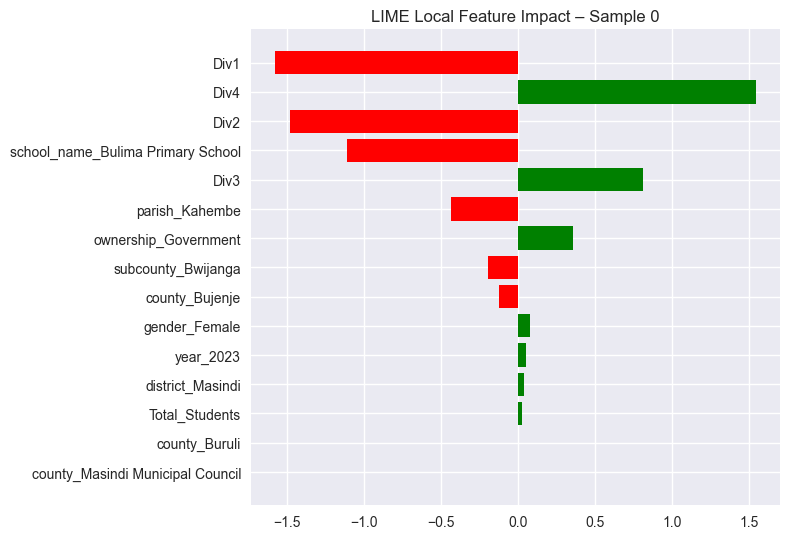


===== LIME EXPLAINABILITY COMPLETE =====

============== LIME TEXTUAL INTERPRETATION =================

 LIME explains **one prediction at a time**, showing which features pushed the prediction *up* or *down*.

▪ Features with **positive contribution** increased the predicted weighted score (weaker performance).
▪ Features with **negative contribution** lowered the predicted score (better performance).

TOP INFLUENTIAL FEATURES FOR THIS STUDENT:
    Div1 --> -1.576   ⬇ reduces score (better)
    Div4 --> 1.542   ⬆ increases score (worse)
    Div2 --> -1.481   ⬇ reduces score (better)
    school_name_Bulima Primary School --> -1.107   ⬇ reduces score (better)
    Div3 --> 0.807   ⬆ increases score (worse)
    parish_Kahembe --> -0.436   ⬇ reduces score (better)
    ownership_Government --> 0.359   ⬆ increases score (worse)
    subcounty_Bwijanga --> -0.196   ⬇ reduces score (better)
    county_Bujenje --> -0.121   ⬇ reduces score (better)
    gender_Female --> 0.076   ⬆ increases score

In [42]:
# ============================================
# 🔍 LIME EXPLAINABILITY – BASELINE XGBOOST
# ============================================

from lime.lime_tabular import LimeTabularExplainer

# ---- Refit Baseline XGBoost Pipeline if needed ----
baseline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    ))
])
baseline_xgb.fit(X_train, y_train)

# ---- Prepare Data for LIME ----
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

feature_names = get_feature_names(preprocessor)

# ---- Initialize LIME explainer ----
explainer_lime = LimeTabularExplainer(
    training_data = X_train_transformed,
    feature_names = feature_names,
    mode = "regression",
    verbose = True
)

# ---- Explain a SINGLE prediction ----
sample_index = 0   # change this index anytime
sample = X_test_transformed[sample_index].reshape(1, -1)

lime_exp = explainer_lime.explain_instance(
    data_row = X_test_transformed[sample_index],
    predict_fn = baseline_xgb.named_steps["model"].predict,
    num_features = 15
)

# ---- VISUAL OUTPUT ----
print(f"\n🔎 LIME EXPLANATION FOR SAMPLE #{sample_index}\n")
display(lime_exp.show_in_notebook(show_table=True))

# Save as image if needed
lime_exp.as_pyplot_figure()
plt.title(f"LIME Local Feature Impact – Sample {sample_index}")
plt.tight_layout()
plt.show()

print("\n===== LIME EXPLAINABILITY COMPLETE =====")
# ======================================================
# TEXTUAL INTERPRETATION OF LIME EXPLANATION
# ======================================================
print("\n============== LIME TEXTUAL INTERPRETATION =================\n")

print(" LIME explains **one prediction at a time**, showing which features pushed the prediction *up* or *down*.\n")
print("▪ Features with **positive contribution** increased the predicted weighted score (weaker performance).")
print("▪ Features with **negative contribution** lowered the predicted score (better performance).")
print("\nTOP INFLUENTIAL FEATURES FOR THIS STUDENT:")
for feat, weight in lime_exp.as_list()[:10]:
    direction = "⬆ increases score (worse)" if weight > 0 else "⬇ reduces score (better)"
    print(f"    {feat} --> {round(weight,3)}   {direction}")

print("\nINTERPRETATION SUMMARY:")
print("• LIME breaks down the prediction like a human explanation.")
print("• Helps identify WHY that specific learner/school output was predicted.")
print("• Great for **case investigation**, interventions, and fairness checks.")
print("\n============== END OF LIME ANALYSIS =================\n")

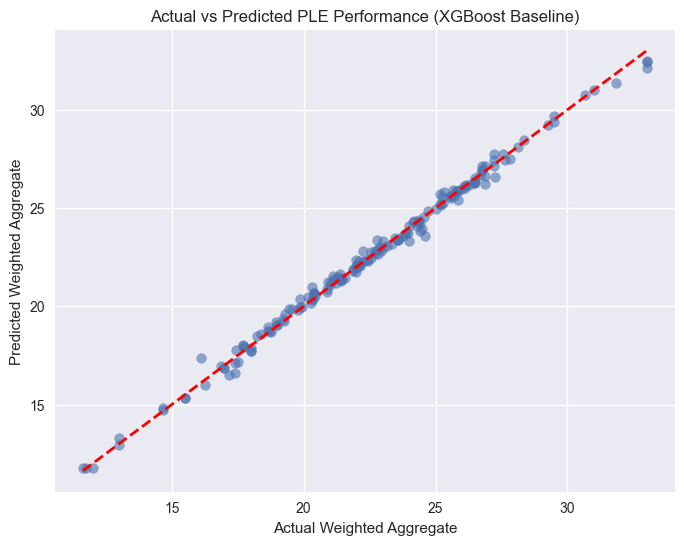


 Interpretation:
• Points close to red line = accurate predictions
• Wide spread from red line = areas where model struggles
• Helps visually trust model behaviour for policy decision-making


In [43]:
# ===================================================
# Actual vs Predicted Plot (Baseline XGBoost)
# ===================================================

best_model = baseline_xgb  # since baseline XGBoost is your winner
preds = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)

plt.xlabel("Actual Weighted Aggregate")
plt.ylabel("Predicted Weighted Aggregate")
plt.title("Actual vs Predicted PLE Performance (XGBoost Baseline)")
plt.grid(True)
plt.show()

print("\n Interpretation:")
print("• Points close to red line = accurate predictions")
print("• Wide spread from red line = areas where model struggles")
print("• Helps visually trust model behaviour for policy decision-making")


In [44]:
# ============================================
#  SAVE FINAL MODEL (BASELINE XGBOOST PIPELINE)
# ============================================

import joblib
import xgboost as xgb
from sklearn.pipeline import Pipeline

# ---- Rebuild baseline XGBoost pipeline (same as earlier) ----
baseline_xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb.XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    ))
])

# ---- Fit the model to your TRAINING data ----
baseline_xgb_pipeline.fit(X_train, y_train)

# ---- Save the fitted pipeline ----
joblib.dump(baseline_xgb_pipeline, "final_xgboost_model.pkl")

print(" Final baseline XGBoost model saved as: final_xgboost_model.pkl")


 Final baseline XGBoost model saved as: final_xgboost_model.pkl


In [45]:
# ============================================
#  LOAD FINAL MODEL
# ============================================

loaded_model = joblib.load("final_xgboost_model.pkl")
print("Model loaded successfully!")

# test a prediction to confirm:
sample_pred = loaded_model.predict(X_test[:5])
sample_pred


Model loaded successfully!


array([17.128134, 20.452148, 29.206953, 17.34707 , 23.08566 ],
      dtype=float32)